In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pankajkarki","key":"563115ce1ea9892ab835dfbe5b8acba1"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d pankajkarki/humana

!ls



 75% 63.0M/84.5M [00:00<00:00, 87.3MB/s]
100% 84.5M/84.5M [00:00<00:00, 144MB/s] 
humana.zip  kaggle.json  sample_data


In [93]:
!unzip humana.zip

Archive:  humana.zip
replace HAR/UCI_HAR_Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/.DS_Store  
replace HAR/UCI_HAR_Dataset/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/_DS_Store  
replace HAR/UCI_HAR_Dataset/activity_labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/activity_labels.txt  
replace HAR/UCI_HAR_Dataset/csv_files/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/csv_files/test.csv  
replace HAR/UCI_HAR_Dataset/csv_files/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/csv_files/train.csv  
replace HAR/UCI_HAR_Dataset/features.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/features.txt  
replace HAR/UCI_HAR_Dataset/features_info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HAR/UCI_HAR_Dataset/features_info.txt  
replace HAR/UCI_HAR_Dataset/REA

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [107]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

# [1] Hyperparameter tuning for neurons and dropout_rate

In [0]:
# Function to create model, required for KerasClassifier
def create_model(neurons, dropout_rate):
	  # create model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(timesteps, input_dim), kernel_initializer='uniform'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, kernel_initializer='uniform', activation='sigmoid'))
	
    print(model.summary())
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    

    return model

In [0]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=40, batch_size=64, verbose=1)

In [89]:
# define the grid search parameters
neurons = [64, 128]
dropout_rate = [0.5, 0.7]

param_grid = dict(neurons=neurons, dropout_rate=dropout_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train, validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_59 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
None
Train on 4901 samples, validate on 2947 samples
Epoch 1/40
4901/4901 [==============================] - 25s 5ms/step - loss: 1.4835 - acc: 0.3734 - val_loss: 1.3747 - val_acc: 0.3536
Epoch 2/40
4901/4901 [==============================] - 11s 2ms/step - loss: 1.2996 - acc: 0.3967 - val_loss: 1.3493 - val_acc: 0.3536
Epoch 3/40
4901/4901 [==============================] - 11s 2ms/step - loss: 1.

In [90]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855277 using {'dropout_rate': 0.5, 'neurons': 128}
0.659820 (0.110190) with: {'dropout_rate': 0.5, 'neurons': 64}
0.855277 (0.046334) with: {'dropout_rate': 0.5, 'neurons': 128}
0.685120 (0.035716) with: {'dropout_rate': 0.7, 'neurons': 64}
0.819097 (0.070899) with: {'dropout_rate': 0.7, 'neurons': 128}


## [1.1]  Validation plots

### [1.1.1] Accuracy on train Vs hyperparameters

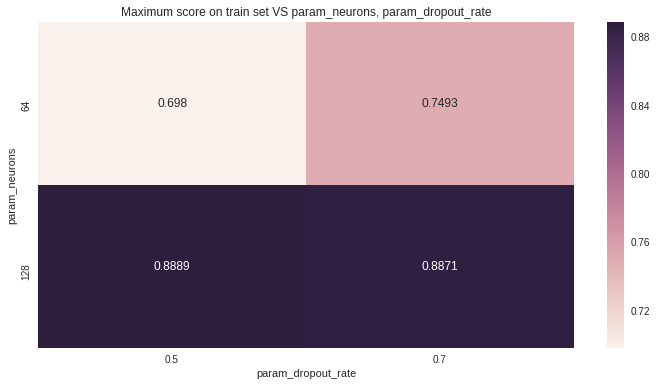

In [91]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

df_gridsearch = pd.DataFrame(grid_result.cv_results_)
max_scores = df_gridsearch.groupby(['param_neurons','param_dropout_rate']).max().unstack()[['mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on train set VS param_neurons, param_dropout_rate'
fmt = 'png'
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

### [1.1.2] Error on train Vs hyperparameters

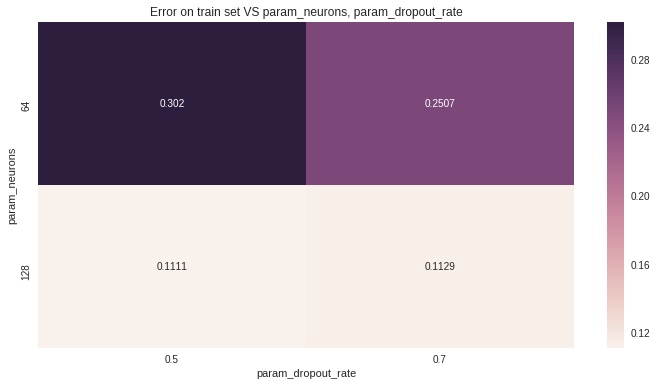

In [122]:
df_gridsearch = pd.DataFrame(grid_result.cv_results_)
max_scores = df_gridsearch.groupby(['param_neurons','param_dropout_rate']).max().unstack()[['mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Error on train set VS param_neurons, param_dropout_rate'
fmt = 'png'
a = max_scores.mean_train_score
b = 1-a
sns.heatmap(b, annot=True, fmt='.4g');
plt.title(title);

### [1.1.3] Accuracy on test Vs hyperparameters

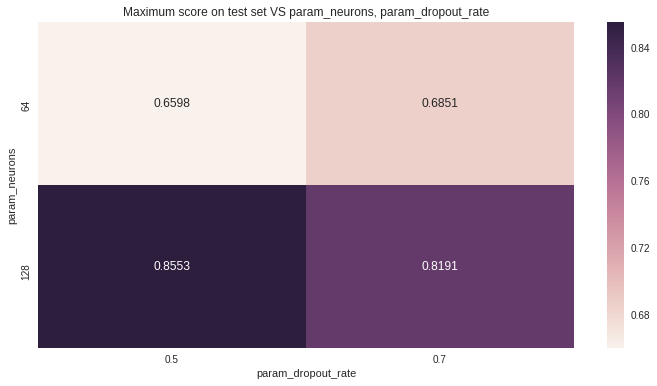

In [92]:
df_gridsearch = pd.DataFrame(grid_result.cv_results_)
max_scores = df_gridsearch.groupby(['param_neurons','param_dropout_rate']).max().unstack()[['mean_test_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_neurons, param_dropout_rate'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### [1.1.4] Error on test Vs hyperparameters

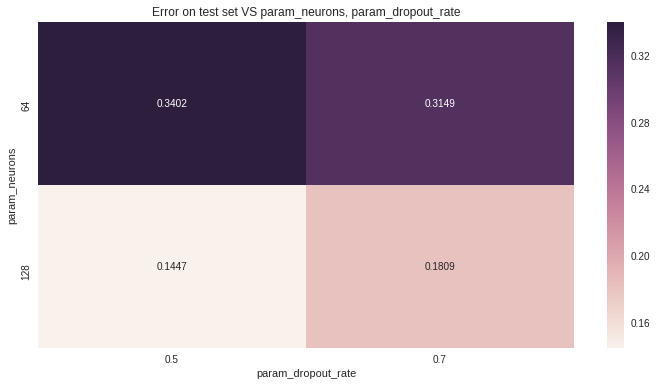

In [123]:
df_gridsearch = pd.DataFrame(grid_result.cv_results_)
max_scores = df_gridsearch.groupby(['param_neurons','param_dropout_rate']).max().unstack()[['mean_test_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Error on test set VS param_neurons, param_dropout_rate'
fmt = 'png'
a = max_scores.mean_test_score
b = 1-a
sns.heatmap(b, annot=True, fmt='.4g');
plt.title(title);

# [1.1] LSTM with best hyperparameter

In [0]:
# Initializing paramtrers
epochs = 40 
batch_size = 64

In [112]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(128, input_shape=(timesteps, input_dim), kernel_initializer='uniform'))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, kernel_initializer='uniform', activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

#Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 43s 6ms/step - loss: 1.4155 - acc: 0.3626 - val_loss: 1.5199 - val_acc: 0.3590
Epoch 2/40
7352/7352 [==============================] - 29s 4ms/step - loss: 1.3196 - acc: 0.4021 - val_loss: 1.2717 - val_acc: 0.4204
Epoch 3/40
7352/7352 [==============================] - 29s 4ms/step - loss: 1.2813 - acc: 0.4260 - val_loss: 1.3083 - val_acc: 0.4086
Epoch 4/40
7352/7352 [==============================] - 29s 4ms/step - loss: 1.2118 - acc: 0.4495 - val_loss: 1.1894 - val_acc: 0.4941
Epoch 5/40
7352/7352 [==============================] - 29s 4ms/step - loss: 1.1284 - acc: 0.5091 - val_loss: 1.1761 - val_acc: 0.5029
Epoch 6/40
7352/7352 [==============================] - 29s 4ms/step - loss: 1.0018 - acc: 0.5853 - val_loss: 0.9945 - val_acc: 0.5921
Epoch 7/40
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9775 - acc: 0.5849 - val_loss: 1.0610 - val_acc: 0.5185
Epoch 8

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

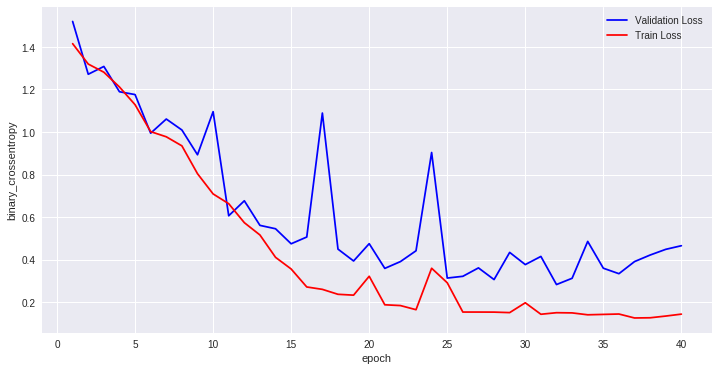

In [115]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Test Score: 0.465158
Test Accuracy: 90.091619%


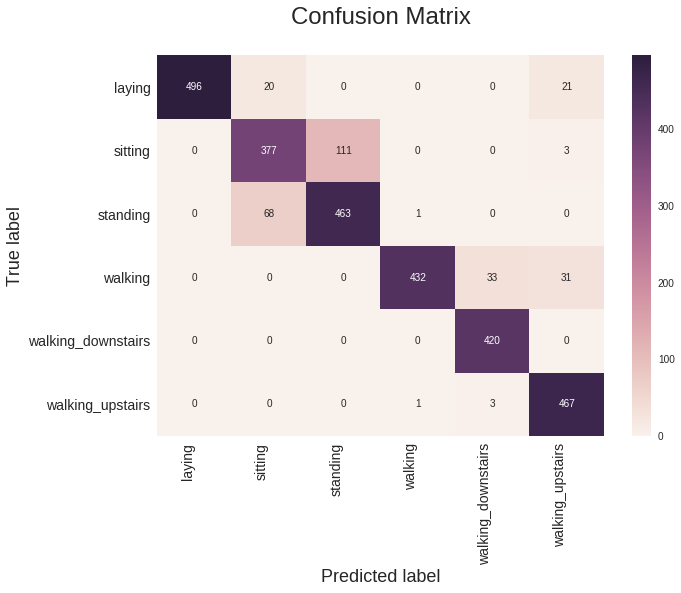

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [2] LSTM with 2 layers

In [0]:
# Initializing parameters
epochs = 15
batch_size = 16

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))

# Configuring the parameters
model.add(LSTM(64))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 81s 11ms/step - loss: 1.1678 - acc: 0.4990 - val_loss: 0.9319 - val_acc: 0.6132
Epoch 2/15
7352/7352 [==============================] - 75s 10ms/step - loss: 0.7962 - acc: 0.6355 - val_loss: 0.8624 - val_acc: 0.5830
Epoch 3/15
7352/7352 [==============================] - 74s 10ms/step - loss: 0.7538 - acc: 0.6557 - val_loss: 0.6314 - val_acc: 0.7299
Epoch 4/15
7352/7352 [==============================] - 74s 10ms/step - loss: 0.6005 - acc: 0.7425 - val_loss: 0.5225 - val_acc: 0.7604
Epoch 5/15
7352/7352 [==============================] - 74s 10ms/step - loss: 0.4737 - acc: 0.7826 - val_loss: 0.5304 - val_acc: 0.7550
Epoch 6/15
7352/7352 [==============================] - 74s 10ms/step - loss: 0.4205 - acc: 0.8045 - val_loss: 0.7414 - val_acc: 0.7350
Epoch 7/15
7352/7352 [==============================] - 74s 10ms/step - loss: 0.3622 - acc: 0.8466 - val_loss: 0.4676 - val_acc: 0.8636


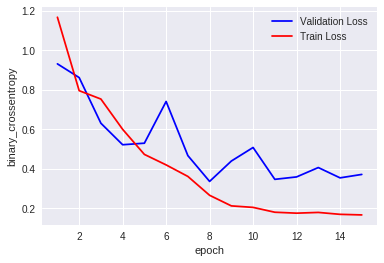

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Test Score: 0.372318
Test Accuracy: 91.584662%


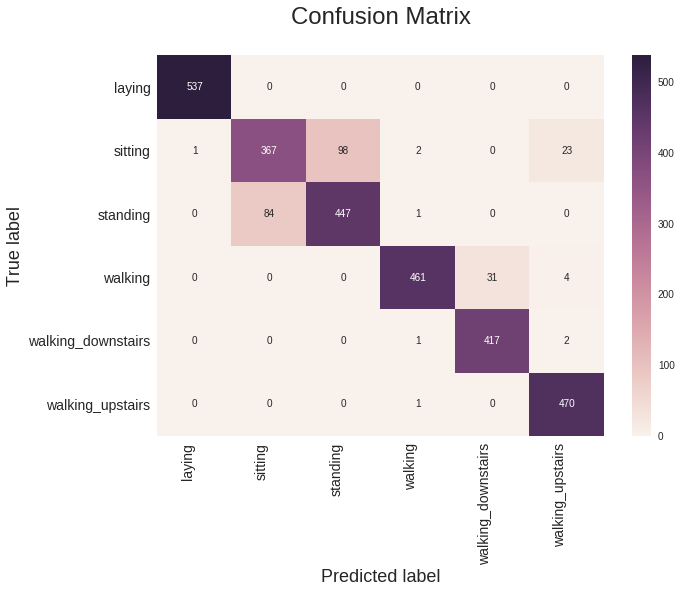

In [0]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Performane Table

In [117]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["MODEL", "TRAIN_ACCURACY", "TEST_ACCURACY"]
x.add_row(["1 LSTM layer with 128 LSTM Units(Optimizer-->rmsprop)", 94.45, 90.09])
x.add_row(["2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)", 94.53, 91.58])

print('\t\tRNN WITH DIFFERNET ARCHITECTURES')
print(x)


		RNN WITH DIFFERNET ARCHITECTURES
+-------------------------------------------------------+----------------+---------------+
|                         MODEL                         | TRAIN_ACCURACY | TEST_ACCURACY |
+-------------------------------------------------------+----------------+---------------+
| 1 LSTM layer with 128 LSTM Units(Optimizer-->rmsprop) |     94.45      |     90.09     |
|  2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) |     94.53      |     91.58     |
+-------------------------------------------------------+----------------+---------------+


# Conclusion:

1. We did Hyperparameter tuning for 1 LSTM layered Architecture for tuning neurons and dropout_rate.
2. After hyperparameter tuning we got best hyperparameter (neurons = 128, dropout_rate = 0.5)
3. And trained model with best hyperparameter got accuracy of 90.09 and a loss of 0.46. 
4. With a simple 2 LSTM layer architecture we got 91.58% test accuracy and a loss of 0.37
